# CNN for AED with Keras/TensorFlow

Date: November 11, 2018

Neural network: three convolution layers and three fully connected layers

Classification of acoustic events:

- Piano music
- Framenco guitar music
- Classical guitar music
- Blues hars music
- Tin whistle music
- Silence

## Preparing data set for CNN

In [9]:
#from google.colab import drive
#drive.mount('/content/gdrive')

DATA_FOLDER = '../oscilloscope/data_music/'

FILTERS=40
FILES = 100
TRAINING_FILES = 67
TEST_FILES = FILES - TRAINING_FILES

In [10]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import random
import os
import sklearn.preprocessing as pp

In [11]:
import glob

data_files = glob.glob(DATA_FOLDER+'*mel_spectrogram*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*mel_spectrogram*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

LENGTH=64
a1, a2 = 0,  FILTERS*64
b1, b2 = FILTERS*64, FILTERS*64*2
c1, c2 = FILTERS*64*2, FILTERS*64*3

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.float)
        #df = df[df['n']<FILTERS]
        img1 = pp.scale(df[a1:a2]['magnitude'].values)
        img2 = pp.scale(df[b1:b2]['magnitude'].values)
        img3 = pp.scale(df[c1:c2]['magnitude'].values)
        training_set.append((img1, class_number))
        training_set.append((img2, class_number))
        training_set.append((img3, class_number))
    files = v[1]
    for file in files:
        df = pd.read_csv(file.replace(os.path.sep, '/'), dtype=np.float)
        #df = df[df['n']<FILTERS]
        img1 = pp.scale(df[a1:a2]['magnitude'].values)
        img2 = pp.scale(df[b1:b2]['magnitude'].values)
        img3 = pp.scale(df[c1:c2]['magnitude'].values)
        test_set.append((img1, class_number))
        test_set.append((img2, class_number))
        test_set.append((img3, class_number))

random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k ))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

5: framenco_guitar
1: piano
3: blues_harp
4: tin_whistle
2: classical_guitar
0: silence


Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.4 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 432, got 412
  return f(*args, **kwds)


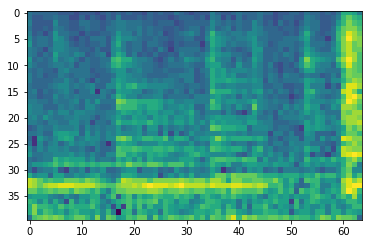

In [12]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data, dtype='float32').reshape((TRAINING_FILES*len(class_labels)*3, LENGTH, FILTERS, 1))
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data, dtype='float32').reshape((TEST_FILES*len(class_labels)*3, LENGTH, FILTERS, 1))
test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(np.rot90(train_data[0, :,:,0]))

### CNN model

In [13]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(LENGTH, FILTERS, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 38, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 19, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 17, 8)         296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 8, 8)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 6, 16)         1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 3, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
__________

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

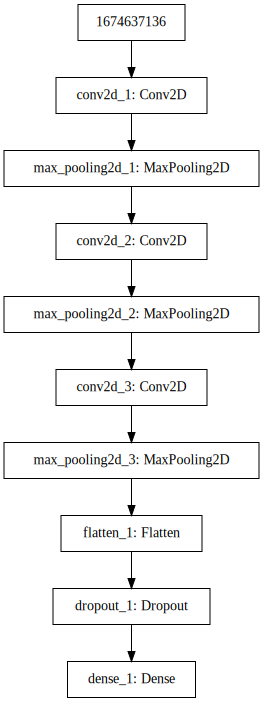

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [16]:
EPOCHS = 30
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 1206 samples, validate on 594 samples
Epoch 1/30
1206/1206 [==============================] - 11s 9ms/step - loss: 1.7648 - acc: 0.2496 - val_loss: 1.6060 - val_acc: 0.3502
Epoch 2/30
1206/1206 [==============================] - 7s 6ms/step - loss: 1.4010 - acc: 0.4876 - val_loss: 1.0746 - val_acc: 0.6498
Epoch 3/30
1206/1206 [==============================] - 7s 6ms/step - loss: 0.9760 - acc: 0.6310 - val_loss: 0.7714 - val_acc: 0.7172
Epoch 4/30
1206/1206 [==============================] - 7s 6ms/step - loss: 0.8084 - acc: 0.6849 - val_loss: 0.6475 - val_acc: 0.7727
Epoch 5/30
1206/1206 [==============================] - 7s 6ms/step - loss: 0.7209 - acc: 0.7189 - val_loss: 0.5921 - val_acc: 0.7778
Epoch 6/30
1206/1206 [==============================] - 7s 6ms/step - loss: 0.6230 - acc: 0.7504 - val_loss: 0.5394 - val_acc: 0.7896
Epoch 7/30
1206/1206 [==============================] - 7s 6ms/step - loss: 0.5721 - acc: 0.7811 - val_loss: 0.4627 - val_acc: 0.8350
Epoch 8/30
120

dict_keys(['val_loss', 'loss', 'acc', 'val_acc'])


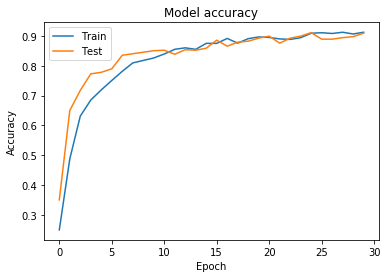

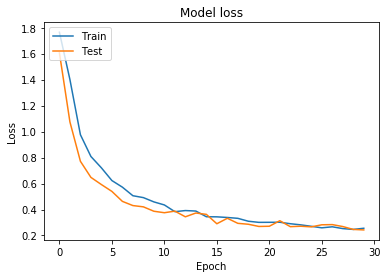

In [17]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [18]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'cnn_for_aed_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [19]:
del model
model = models.load_model(filename)

## Confirmation

In [20]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(1206, 64, 40, 1)

In [21]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [22]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [23]:
class_labels

['silence',
 'piano',
 'classical_guitar',
 'blues_harp',
 'tin_whistle',
 'framenco_guitar']

In [24]:
(activations[-1][:10]*100).astype(int)

array([[ 0,  0,  0,  2,  0, 97],
       [98,  1,  0,  0,  0,  0],
       [ 0, 13, 78,  0,  0,  6],
       [99,  0,  0,  0,  0,  0],
       [ 0, 97,  0,  0,  2,  0],
       [ 0,  0,  0, 99,  0,  0],
       [ 0,  0,  0,  0, 99,  0],
       [97,  2,  0,  0,  0,  0],
       [ 0, 96,  3,  0,  0,  0],
       [ 0,  5, 27,  8,  0, 57]])

In [25]:
test_labels[:10].astype(int)

array([[0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]])

In [26]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(np.rot90(activations[layer][sample, :, :, i]))
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'tin_whistle'

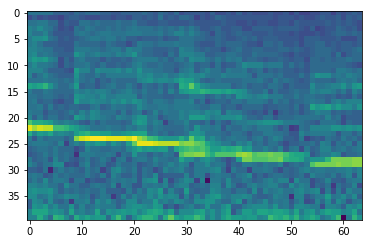

In [27]:
image_number = 25

plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

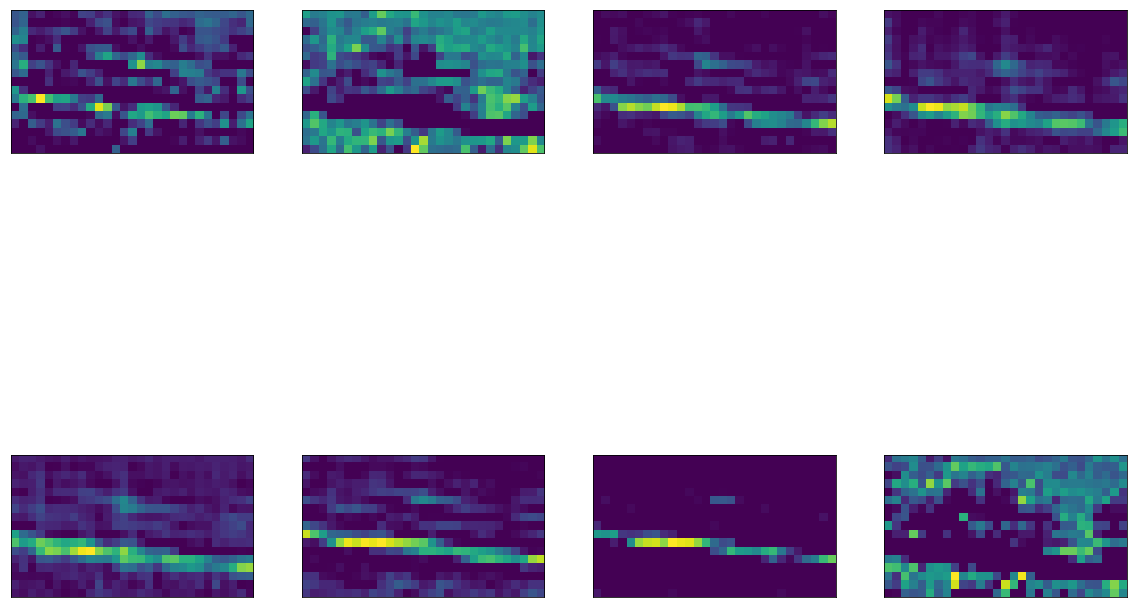

In [28]:
plot_layer(activations, image_number, 2)

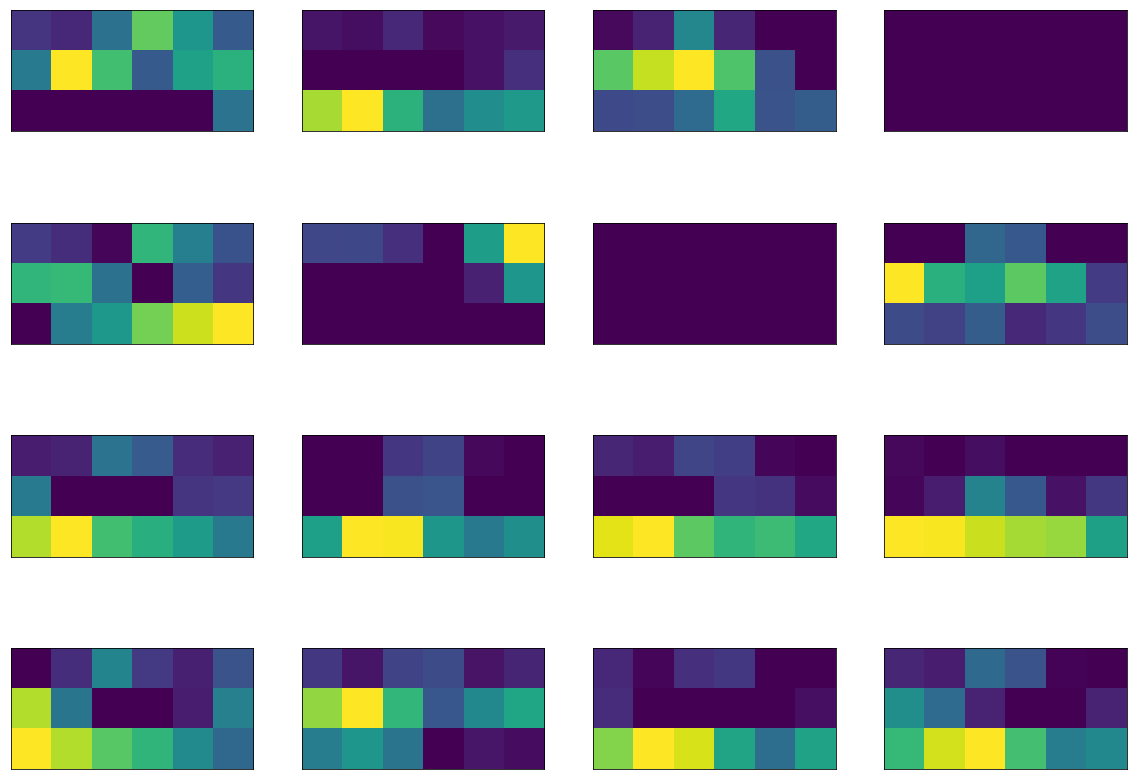

In [29]:
plot_layer(activations, image_number, 5)